This notebook attempts to compare simulations to Gelles2021: https://arxiv.org/pdf/2105.09440.pdf
---
The simple geometrical configurations implemented are:
 - Idealized (infinitely thin) equatorial ring
 - Idealized equatorial hotpot (point source) 

In [1]:
import bhnerf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Welcome to eht-imaging! v 1.2 



# Ring emission

## Figures 1-2

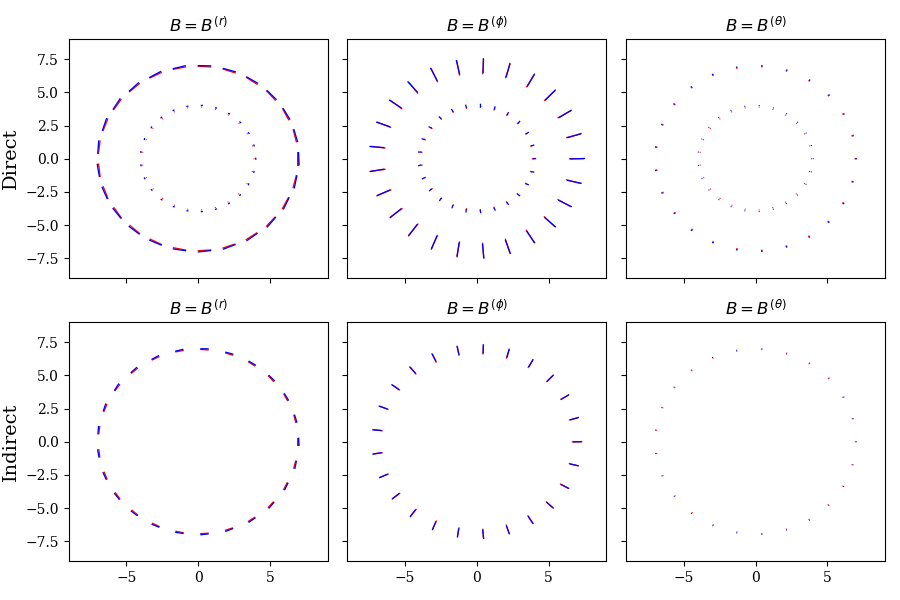

In [22]:
inclination = 0.01
ngeo = 1000
num_points = 25
observer_coords = [0, 1000.0, inclination, 0]
varphis = np.linspace(0, 2*np.pi, num_points, endpoint=False)
beta_v, chi = 0.0, 0.0
g = 1
mbar = 0

%matplotlib widget
titles = [r'$B=B^{(r)}$', r'$B=B^{(\phi)}$', r'$B=B^{(\theta)}$']
fig, axes = plt.subplots(2, 3, figsize=(9,6), sharey=True, sharex=True)

for k, scale, emission_rs in zip([0, 1], [0.05, 0.08], [[3, 6], [6]]):
    for spin, color in zip([0., -0.99], ['r', 'b']):
        for emission_r in emission_rs:
            alpha, beta = bhnerf.kgeo.equatorial_lensing.rho_of_req(spin, inclination, req=emission_r, mbar=mbar, varphis=varphis)[-2:]
            geos = bhnerf.kgeo.raytrace_ana(spin, observer_coords, [alpha, beta], ngeo, plotdata=False, verbose=False).get_dataset()
            emission = bhnerf.emission.equatorial_ring(geos, mbar)
            umu = bhnerf.kgeo.zamo_frame_velocity(geos, beta_v, chi)
            
            # Minus to theta component is due to opposite coordinate compares to Gelles2021
            b_r = bhnerf.kgeo.magnetic_field(geos, 1.0, 0.0, 0.0)
            b_th = bhnerf.kgeo.magnetic_field(geos, 0.0, -1.0, 0.0) 
            b_ph = bhnerf.kgeo.magnetic_field(geos, 0.0, 0.0, 1.0) 
            
            for i, b in enumerate([b_r, b_ph, b_th]):
                J = emission.data * bhnerf.kgeo.parallel_transport(geos, umu, g, b)
                J = bhnerf.kgeo.radiative_trasfer(J, g, np.array(geos.dtau), np.array(geos.Sigma))
                bhnerf.visualization.plot_evpa_ticks(J[1], J[2], geos.alpha, geos.beta, axes[k,i], scale=scale, color=color)
                axes[k,i].set_title(titles[i])
                axes[k,i].set_xlim(-9, 9)
                axes[k,i].set_ylim(-9, 9)
axes[0, 0].set_ylabel('Direct', fontsize=14)
axes[1, 0].set_ylabel('Indirect', fontsize=14)
plt.tight_layout()

## Figures 3-4

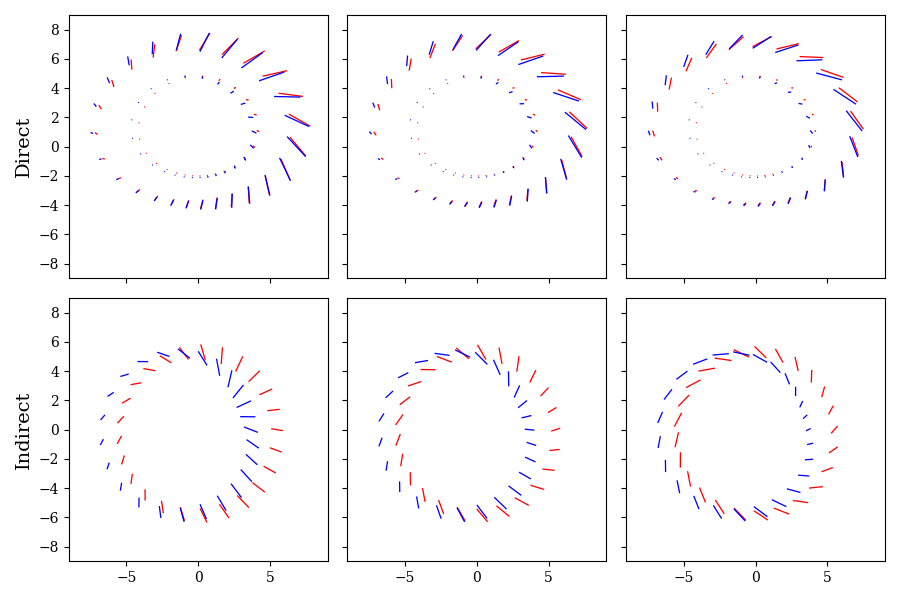

In [23]:
inclination = np.deg2rad(50)
ngeo = 1000
num_points = 25
observer_coords = [0, 1000.0, inclination, 0]
varphis = np.linspace(0, 2*np.pi, num_points, endpoint=False)
g = 1

beta_v_arr = [0.3, 0.3, 0.3]
chi_arr = np.deg2rad([-120, -135, -150])
b_arr = [bhnerf.kgeo.magnetic_field(geos, 0.50, 0.0, 0.87),
         bhnerf.kgeo.magnetic_field(geos, 0.71, 0.0, 0.71),
         bhnerf.kgeo.magnetic_field(geos, 0.87, 0.0, 0.50)]

%matplotlib widget
titles = [r'$B=B^{(r)}$', r'$B=B^{(\phi)}$', r'$B=B^{(\theta)}$']
fig, axes = plt.subplots(2, 3, figsize=(9,6), sharey=True, sharex=True)

for k, scale, emission_rs in zip([0, 1], [60, 90], [[3, 6], [6]]):
    for spin, color in zip([0.001, -0.99], ['r', 'b']):
        for emission_r in emission_rs:
            alpha, beta = bhnerf.kgeo.equatorial_lensing.rho_of_req(spin, inclination, req=emission_r, mbar=k, varphis=varphis)[-2:]
            geos = bhnerf.kgeo.raytrace_ana(spin, observer_coords, [alpha, beta], ngeo, plotdata=False, verbose=False).get_dataset()
            emission = bhnerf.emission.equatorial_ring(geos, k)
            
            for i, (beta_v, chi, b) in enumerate(zip(beta_v_arr, chi_arr, b_arr)):
                umu = bhnerf.kgeo.zamo_frame_velocity(geos, beta_v, chi)
                J = emission.data * bhnerf.kgeo.parallel_transport(geos, umu, g, b)
                J = bhnerf.kgeo.radiative_trasfer(J, g, 1.0, np.array(geos.Sigma))
                bhnerf.visualization.plot_evpa_ticks(J[1], J[2], geos.alpha, geos.beta, axes[k,i], scale=scale, color=color)
                axes[k,i].set_xlim(-9, 9)
                axes[k,i].set_ylim(-9, 9)
axes[0, 0].set_ylabel('Direct', fontsize=14)
axes[1, 0].set_ylabel('Indirect', fontsize=14)
plt.tight_layout()

# EVPA vs emission radius

## Figure 5

In [24]:
inclination = 0.0001
ngeo = 1000
observer_coords = [0, 1000.0, inclination, 0]
varphis = [0.0]
beta_v, chi = 0.0, 0.0
emission_rs = np.linspace(3, 20, 30)
mbar = 0
g = 1
evpa = np.empty((3, 2, len(emission_rs)))

for k, rs in enumerate(emission_rs):
    for j, spin in enumerate([0.0, -0.99]):
        alpha, beta = bhnerf.kgeo.equatorial_lensing.rho_of_req(spin, inclination, req=rs, mbar=mbar, varphis=varphis)[-2:]
        geos = bhnerf.kgeo.raytrace_ana(spin, observer_coords, [alpha, beta], ngeo, plotdata=False, verbose=False).get_dataset()
        emission = bhnerf.emission.equatorial_ring(geos, mbar)
        umu = bhnerf.kgeo.zamo_frame_velocity(geos, beta_v, chi)
        
        # Minus to theta component is due to opposite coordinate compares to Gelles2021
        b_r = bhnerf.kgeo.magnetic_field(geos, 1.0, 0.0, 0.0)
        b_th = bhnerf.kgeo.magnetic_field(geos, 0.0, -1.0, 0.0) 
        b_ph = bhnerf.kgeo.magnetic_field(geos, 0.0, 0.0, 1.0) 
            
        for i, b in enumerate([b_r, b_ph, b_th]):
            J = emission.data * bhnerf.kgeo.parallel_transport(geos, umu, g, b)
            J = bhnerf.kgeo.radiative_trasfer(J, g, np.array(geos.dtau), np.array(geos.Sigma))
            evpa[i,j,k] = np.arctan2(J[2], J[1]) / 2

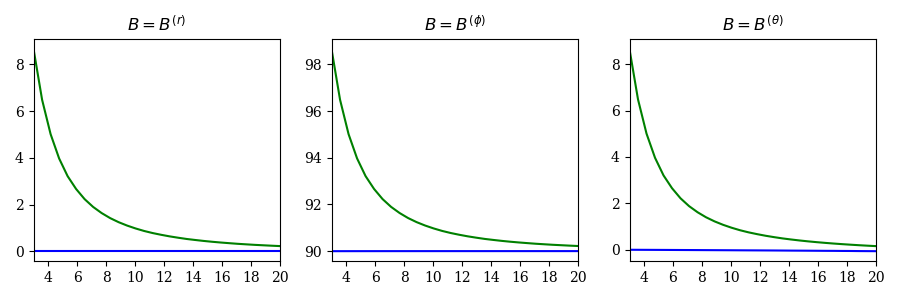

In [25]:
%matplotlib widget
titles = [r'$B=B^{(r)}$', r'$B=B^{(\phi)}$', r'$B=B^{(\theta)}$']
fig, axes = plt.subplots(1, 3, figsize=(9,3))
colors = ['b', 'g']
for i, ax in enumerate(axes):
    ax.set_title(titles[i])
    for j in range(2):
        if (i==0) or (i==2):
            ax.plot(emission_rs, np.rad2deg(evpa[i,j]), color=colors[j])
        else:
            ax.plot(emission_rs, (180 + np.rad2deg(evpa[i,j])) % 180, color=colors[j])
    ax.set_xlim(3,20)
    ax.set_xticks(np.arange(4,22,2))
plt.tight_layout()

## Figure 6

In [26]:
inclination = 0.0001
ngeo = 1000
observer_coords = [0, 1000.0, inclination, 0]
beta_v, chi = 0.0, 0.0
varphis = [0.0]
mbar = 0
g = 1
emission_rs = np.linspace(3, 20, 30)

evpa = np.empty((3, 4, len(emission_rs)))
for k, rs in enumerate(emission_rs):
    for j, (spin, mbar) in enumerate(zip([0.0, -0.99, -0.99, -0.99], range(4))):
        alpha, beta = bhnerf.kgeo.equatorial_lensing.rho_of_req(spin, inclination, req=rs, mbar=mbar, varphis=varphis)[-2:]
        geos = bhnerf.kgeo.raytrace_ana(spin, observer_coords, [alpha, beta], ngeo, plotdata=False, verbose=False).get_dataset()
        emission = bhnerf.emission.equatorial_ring(geos, mbar)
        umu = bhnerf.kgeo.zamo_frame_velocity(geos, beta_v, chi)

        # Minus to theta component is due to opposite coordinate compares to Gelles2021
        b_r = bhnerf.kgeo.magnetic_field(geos, 1.0, 0.0, 0.0)
        b_th = bhnerf.kgeo.magnetic_field(geos, 0.0, -1.0, 0.0) 
        b_ph = bhnerf.kgeo.magnetic_field(geos, 0.0, 0.0, 1.0) 
            
        for i, b in enumerate([b_r, b_ph, b_th]):
            J = emission.data * bhnerf.kgeo.parallel_transport(geos, umu, g, b)
            J = bhnerf.kgeo.radiative_trasfer(J, g, np.array(geos.dtau), np.array(geos.Sigma))
            evpa[i,j,k] = np.arctan2(J[2], J[1]) / 2

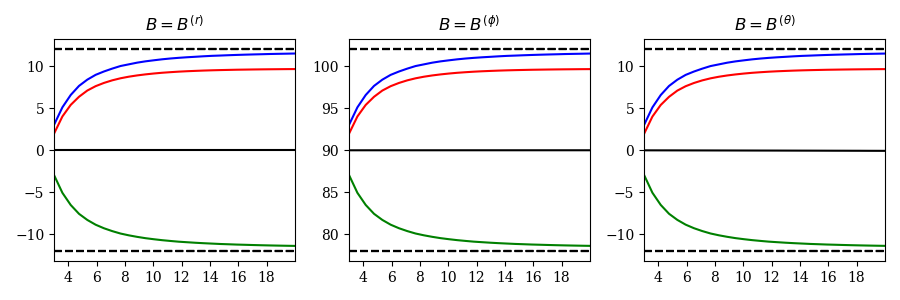

In [27]:
%matplotlib widget
titles = [r'$B=B^{(r)}$', r'$B=B^{(\phi)}$', r'$B=B^{(\theta)}$']
fig, axes = plt.subplots(1, 3, figsize=(9,3))
colors = ['black', 'r', 'g', 'b']
for i, ax in enumerate(axes):
    ax.set_title(titles[i])
    for j in range(4):
        if (i==0) or (i==2):
            ax.axhline(12, linestyle='--', color='black')
            ax.axhline(-12, linestyle='--', color='black')
            ax.plot(emission_rs, np.rad2deg(evpa[i,j]), color=colors[j])
        else:
            ax.axhline(12+90, linestyle='--', color='black')
            ax.axhline(-12+90, linestyle='--', color='black')
            ax.plot(emission_rs, (180 + np.rad2deg(evpa[i,j])) % 180, color=colors[j])

    ax.set_xlim(3,20)
    ax.set_xticks(np.arange(4,20,2))
plt.tight_layout()

# Hotspot emission

## Figure 7

In [28]:
nt = 180
ngeo = 500
inc_list = np.deg2rad([20.0, 45.0, 70.0])
rs_list = [6, 8, 10]
spin_list = [0.001, -0.99]
varphis = np.linspace(0, 2*np.pi, nt)
mbar = 0
chi = -np.pi/2
b_values = [0.71, 0, 0.71]
J_array = np.empty((3,3,2,3,nt))

for i in tqdm(range(3)):
    for j in tqdm(range(3), leave=False): 
        for k in tqdm(range(2), leave=False):
            spin = spin_list[k]
            inc, rs = inc_list[i], rs_list[j]
            observer_coords = [0, 1000.0, inc, 0]
            alpha, beta = bhnerf.kgeo.equatorial_lensing.rho_of_req(spin, inc, req=rs, mbar=mbar, varphis=varphis)[-2:]
            geos = bhnerf.kgeo.raytrace_ana(spin, observer_coords, [alpha, beta], ngeo, plotdata=False, verbose=False).get_dataset()
            emission = bhnerf.emission.equatorial_ring(geos, mbar)
            
            beta_v = (geos.spin**2 - 2*np.abs(geos.spin)*np.sqrt(rs) + rs**2) / (np.sqrt(geos.spin**2 + rs*(rs-2)) * (np.abs(geos.spin) + rs**(3/2)))
            umu = bhnerf.kgeo.zamo_frame_velocity(geos, beta_v, chi)
            g = bhnerf.kgeo.doppler_factor(geos, umu)
        
            b = bhnerf.kgeo.magnetic_field(geos, *b_values)
            J = emission.data * bhnerf.kgeo.parallel_transport(geos, umu, g, b)
            J_array[i,j,k,...] = bhnerf.kgeo.radiative_trasfer(J, g, 1.0, np.array(geos.Sigma))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

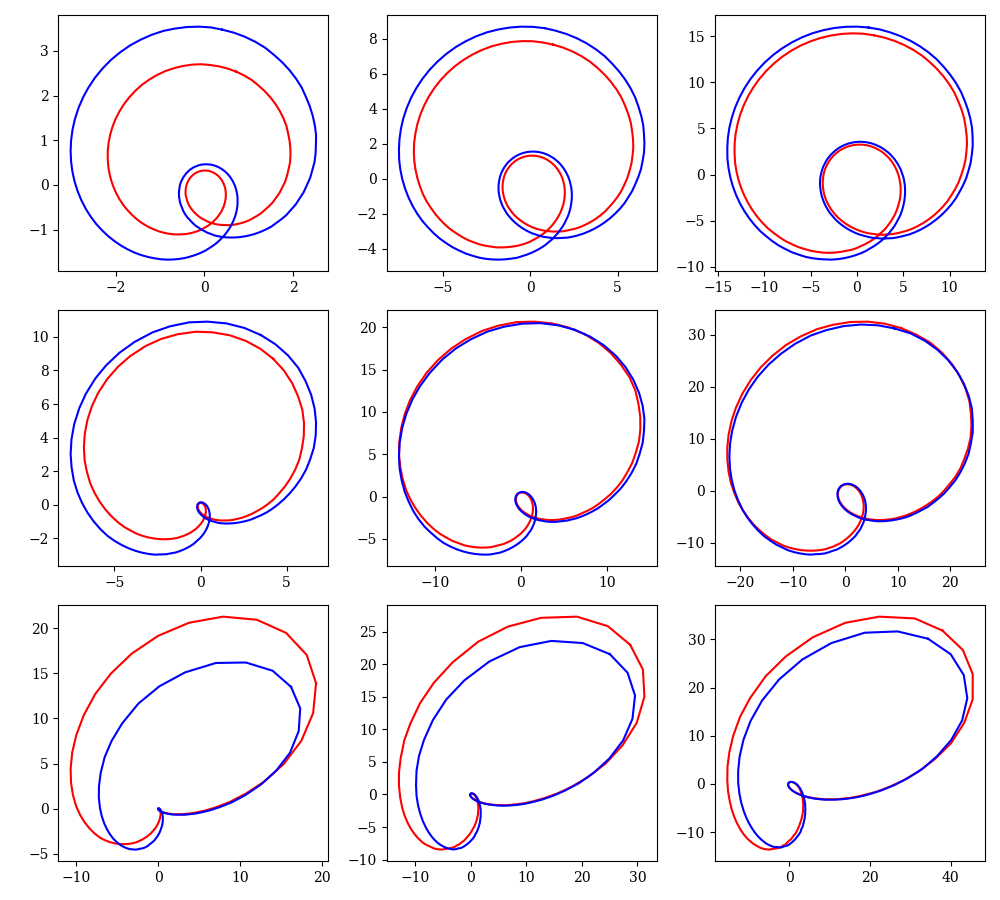

In [29]:
%matplotlib widget
fig, axes = plt.subplots(3, 3, figsize=(10,9))
for i in range(3):
    for j in range(3): 
        for k, color in enumerate(['r', 'b']):
            axes[i,j].plot(J_array[i,j,k,1], J_array[i,j,k,2], color=color)
plt.tight_layout()

In [30]:
nt = 180
ngeo = 500
inc_list = np.deg2rad([20.0, 45.0, 70.0])
rs_list = [6, 8, 10]
spin_list = [0.001, -0.99]
varphis = np.linspace(0, 2*np.pi, nt)
mbar = 0
chi = -np.pi/2
b_values = [0.0, -1.0, 0.0]
J_array = np.empty((3,3,2,3,nt))

for i in tqdm(range(3)):
    for j in tqdm(range(3), leave=False): 
        for k in tqdm(range(2), leave=False):
            spin = spin_list[k]
            inc, rs = inc_list[i], rs_list[j]
            observer_coords = [0, 1000.0, inc, 0]
            alpha, beta = bhnerf.kgeo.equatorial_lensing.rho_of_req(spin, inc, req=rs, mbar=mbar, varphis=varphis)[-2:]
            geos = bhnerf.kgeo.raytrace_ana(spin, observer_coords, [alpha, beta], ngeo, plotdata=False, verbose=False).get_dataset()
            emission = bhnerf.emission.equatorial_ring(geos, mbar)
            
            beta_v = (geos.spin**2 - 2*np.abs(geos.spin)*np.sqrt(rs) + rs**2) / (np.sqrt(geos.spin**2 + rs*(rs-2)) * (np.abs(geos.spin) + rs**(3/2)))
            umu = bhnerf.kgeo.zamo_frame_velocity(geos, beta_v, chi)
            g = bhnerf.kgeo.doppler_factor(geos, umu)
        
            b = bhnerf.kgeo.magnetic_field(geos, *b_values)
            J = emission.data * bhnerf.kgeo.parallel_transport(geos, umu, g, b)
            J_array[i,j,k,...] = bhnerf.kgeo.radiative_trasfer(J, g, 1.0, np.array(geos.Sigma))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

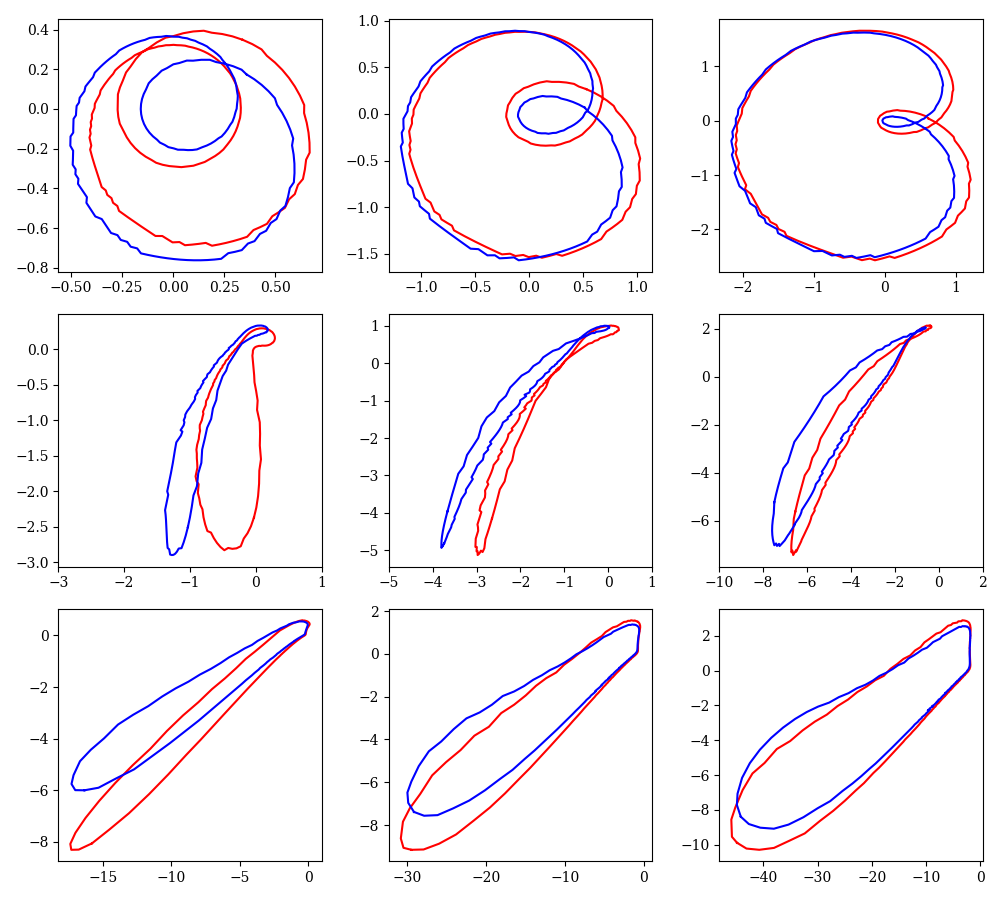

In [31]:
%matplotlib widget
fig, axes = plt.subplots(3, 3, figsize=(10,9))
for i in range(3):
    for j in range(3): 
        for k, color in enumerate(['r', 'b']):
            axes[i,j].plot(J_array[i,j,k,1], J_array[i,j,k,2], color=color)

axes[1,0].set_xlim([-3,1])
axes[1,1].set_xlim([-5,1])
axes[1,2].set_xlim([-10,2])
plt.tight_layout()

## Figure 9

(-180.0, 180.0)

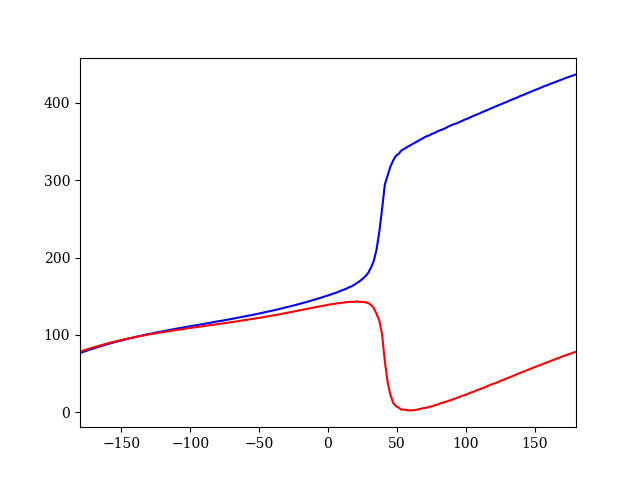

In [32]:
nt = 180
ngeo = 500
inc_list = np.deg2rad([38.0, 43.0])
rs = 6
spin = 0.0001
varphis = np.linspace(-np.pi, np.pi, nt)
mbar = 0
chi = -np.pi/2
b_values = [0.0, -1.0, 0.0]

evpa = []
for inc in inc_list:
    observer_coords = [0, 1000.0, inc, 0]
    alpha, beta = bhnerf.kgeo.equatorial_lensing.rho_of_req(spin, inc, req=rs, mbar=mbar, varphis=varphis)[-2:]
    geos = bhnerf.kgeo.raytrace_ana(spin, observer_coords, [alpha, beta], ngeo, plotdata=False, verbose=False).get_dataset()
    emission = bhnerf.emission.equatorial_ring(geos, mbar)

    beta_v = (geos.spin**2 - 2*np.abs(geos.spin)*np.sqrt(rs) + rs**2) / (np.sqrt(geos.spin**2 + rs*(rs-2)) * (np.abs(geos.spin) + rs**(3/2)))
    umu = bhnerf.kgeo.zamo_frame_velocity(geos, beta_v, chi)
    g = bhnerf.kgeo.doppler_factor(geos, umu)

    b = bhnerf.kgeo.magnetic_field(geos, *b_values)
    J = emission.data * bhnerf.kgeo.parallel_transport(geos, umu, g, b)
    J = bhnerf.kgeo.radiative_trasfer(J, g, 1.0, np.array(geos.Sigma))
    evpa.append(np.arctan2(J[2], J[1]) / 2) 
    
    
%matplotlib widget
evpa0 = np.rad2deg(evpa[0])
evpa0[12:] += 180
evpa0[110:] += 180

evpa1 = np.rad2deg(evpa[1])
evpa1[11:] += 180
evpa1[110:] -= 180

plt.plot(np.rad2deg(varphis), evpa0, color='b')
plt.plot(np.rad2deg(varphis), evpa1, color='r')
plt.xlim(-180, 180)

## Figure 10

In [34]:
nt = 180
ngeo = 500
rs = 6
spin = 0.0
varphis = np.linspace(-np.pi, np.pi, nt)
inc = np.deg2rad(11.0)
b_values = (1/np.sqrt(6)) * np.array([1, -2, 1])
mbar = 0
chi = -np.pi/2

J = []
for mbar in range(2):
    observer_coords = [0, 1000.0, inc, 0]
    alpha, beta = bhnerf.kgeo.equatorial_lensing.rho_of_req(spin, inc, req=rs, mbar=mbar, varphis=varphis)[-2:]
    geos = bhnerf.kgeo.raytrace_ana(spin, observer_coords, [alpha, beta], ngeo, plotdata=False, verbose=False).get_dataset()
    emission = bhnerf.emission.equatorial_ring(geos, mbar)
    beta_v = (geos.spin**2 - 2*np.abs(geos.spin)*np.sqrt(rs) + rs**2) / (np.sqrt(geos.spin**2 + rs*(rs-2)) * (np.abs(geos.spin) + rs**(3/2)))
    umu = bhnerf.kgeo.zamo_frame_velocity(geos, beta_v, chi)
    g = bhnerf.kgeo.doppler_factor(geos, umu)
    b = bhnerf.kgeo.magnetic_field(geos, *b_values)
    stokes = emission.data * bhnerf.kgeo.parallel_transport(geos, umu, g, b)
    J.append(bhnerf.kgeo.radiative_trasfer(stokes, g, 1.0, np.array(geos.Sigma)))

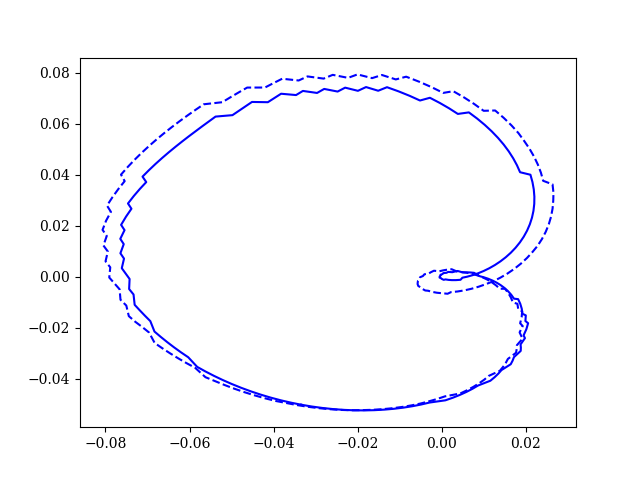

In [35]:
%matplotlib widget
plt.plot(J[0][1], J[0][2], color='b')
c = -0.006
plt.plot(J[0][1] + c*J[1][1], J[0][2] + c*J[1][2], color='b', linestyle='--')

## Figure 12

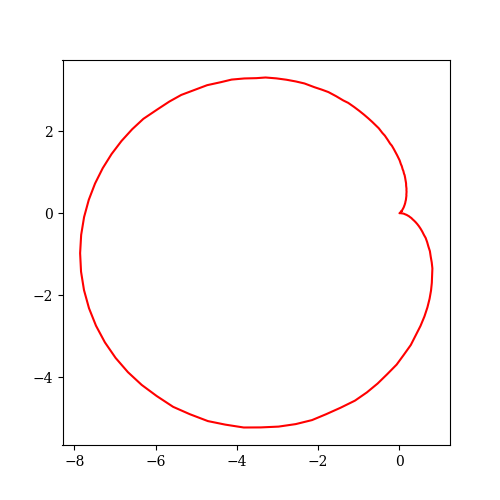

In [36]:
nt = 180
ngeo = 500
rs = 8
spin = 0.0
mbar = 0
chi = -np.pi/2
varphis = np.linspace(-np.pi, np.pi, nt)
b_values = (1/np.sqrt(2)) * np.array([0.0, -1, 1])

evpa = []
inc = np.deg2rad(31.0)
observer_coords = [0, 1000.0, inc, 0]
alpha, beta = bhnerf.kgeo.equatorial_lensing.rho_of_req(spin, inc, req=rs, mbar=mbar, varphis=varphis)[-2:]
geos = bhnerf.kgeo.raytrace_ana(spin, observer_coords, [alpha, beta], ngeo, plotdata=False, verbose=False).get_dataset()
beta_v = (geos.spin**2 - 2*np.abs(geos.spin)*np.sqrt(rs) + rs**2) / (np.sqrt(geos.spin**2 + rs*(rs-2)) * (np.abs(geos.spin) + rs**(3/2)))
emission = bhnerf.emission.equatorial_ring(geos, mbar)
beta_v = (geos.spin**2 - 2*np.abs(geos.spin)*np.sqrt(rs) + rs**2) / (np.sqrt(geos.spin**2 + rs*(rs-2)) * (np.abs(geos.spin) + rs**(3/2)))
umu = bhnerf.kgeo.zamo_frame_velocity(geos, beta_v, chi)
g = bhnerf.kgeo.doppler_factor(geos, umu)
b = bhnerf.kgeo.magnetic_field(geos, *b_values)
J = emission.data * bhnerf.kgeo.parallel_transport(geos, umu, g, b)
J = bhnerf.kgeo.radiative_trasfer(J, g, 1.0, np.array(geos.Sigma))

%matplotlib widget
plt.figure(figsize=(5,5))
plt.plot(J[1], J[2], color='r')